# Objectives
The objective of this project is to develop a real-time weather prediction model using a stream learning approach with the River library. Specifically, we aim to predict whether the temperature will increase or decrease in the next 6 hours based on hourly weather data collected over around one year (2024-2025).

Weather prediction is a complex and dynamic task due to the continuous changes in atmospheric conditions. Using a stream learning approach allows the model to adapt to new patterns over time. Concept drift can occur between different seasons, where the changes in temperature follow different trends depending on the time of year.

Our main goal is to classify whether the temperature at a given time step will be higher or lower in 6 hours. This binary classification task will help in short-term weather forecasting, which is valuable for various sectors such as architecture or energy management.

The prediction is made using weather data from the current time step such as hummidity, pressure, or wind speed. Additionally, we also incorporate some features using the information from the 6 previous time steps. This features represent the average temperature over the current and these 6 previous time steps. This approach provides the model with some contextual information.

In [352]:
# Batch learning will fail if scikit is not downgraded for compatibility with river
%pip install scikit-learn==1.5.2


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [333]:
# Reading data and plot it.
import pandas as pd
import matplotlib.pyplot as plt

# Stream learning
from river import compose, preprocessing, linear_model, tree, metrics, evaluate, feature_extraction, \
    utils, stats, compat, drift, stream

# Batch learning 
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import copy
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, roc_auc_score

# Load dataset

We used a dataset obtained from openweathermap.org,  specifically from their historical data repository. Thanks to the student plan offered by the platform, we obtained an access token, allowing us to make up to 3,000 API calls per minute to retrieve information from their historical database.

For this study, we selected A Coruña as the target location for our data requests. We were able to obtain hourly information from February 2024 to February 2025. Next, we will provide a more detailed explanation of this data.

In [350]:
# Read api request from a csv
converters = {
    # The first column is an index:
    "": lambda x: int(x) if x != "" else None,
    "dt": lambda x: int(x), # UNIX type timestamp with second precision, must be an int to feed it to the models
    "main.temp": lambda x: float(x),
    "main.feels_like": lambda x: float(x),
    "main.pressure": lambda x: int(x), # API gives int precision
    "main.humidity": lambda x: int(x), # API gives int precision
    "main.temp_min": lambda x: float(x),
    "main.temp_max": lambda x: float(x),
    "wind.speed": lambda x: float(x),
    "wind.deg": lambda x: int(x), # rotation degrees in int precision
    "wind.gust": lambda x: float(x) if x != "" else np.nan,
    "clouds.all": lambda x: int(x), # percentage of cloudiness in int precision
    "weather.id": lambda x: int(x), # the id is an integer
    "weather.main": lambda x: x,  # string conversion is implicit
    "weather.description": lambda x: x, # string
    "weather.icon": lambda x: x, # string
    "rain.1h": lambda x: float(x) if x != "" else np.nan # rain volume in mm
}

df = pd.read_csv("datasets/data.csv", converters=converters)
df.describe()

,Unnamed: 0,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,rain.1h
count,8105.000000,8.105000e+03,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,1279.000000,8105.000000,8105.000000,400.000000
mean,4052.000000,1.723207e+09,15.223013,14.867462,1016.258606,83.708822,14.090116,16.279006,3.732584,183.830845,8.259398,41.251203,775.645774,0.353050
std,2339.856299,8.426632e+06,4.343804,4.948661,8.609523,10.288154,4.354793,4.421052,2.353262,110.814811,5.200455,35.334767,86.139847,0.280155
min,0.000000,1.708618e+09,0.400000,-2.620000,976.000000,0.000000,0.400000,2.470000,0.000000,0.000000,0.450000,0.000000,200.000000,0.100000
25%,2026.000000,1.715911e+09,12.260000,11.760000,1012.000000,78.000000,11.360000,13.270000,2.060000,117.000000,3.580000,0.000000,800.000000,0.190000
50%,4052.000000,1.723205e+09,15.260000,15.080000,1017.000000,86.000000,14.320000,16.070000,3.130000,180.000000,7.600000,40.000000,801.000000,0.260000
75%,6078.000000,1.730498e+09,18.360000,18.390000,1021.000000,91.000000,17.160000,19.400000,4.920000,280.000000,12.350000,75.000000,803.000000,0.420000
max,8104.000000,1.737817e+09,30.820000,34.060000,1038.000000,100.000000,29.750000,33.150000,18.780000,360.000000,25.210000,100.000000,804.000000,2.050000


**Feature description**

* dt: UNIX timestamp (seconds since February, 2024).
* main.temp: Current temperature in degrees Celsius.
* main.feels_like: This temperature parameter accounts for the human perception of weather.
* main.pressure: Atmospheric pressure on the sea level, hPa.
* main.humidity: Humidity, %.
* main.temp_min: Minimum temperature within a large city or a megalopolis.
* main.temp_max:  Maximum temperature within a large city or a megalopolis.
* wind.speed: Wind speed, m/s.
* wind.deg: Wind direction, degrees.
* wind.gust: Wind gust, m/s, NaN if not available.
* clouds.all: Cloudiness, %.
* weather.id: Weather condition id.
* weather.main: Group of weather parameters (Rain, Snow, Clouds etc.).
* weather.description: Weather condition within the group.
* weather.icon: Weather icon id.
* rain.1h: Rain volume for the last 1 hour, mm.

In [351]:
# Create the target feature and eliminate redundant features
df["temp_diff_6h"] = df["main.temp"].diff(periods=6)
df["target"] = (df["temp_diff_6h"] > 0).astype(int)
df = df.drop(["Unnamed: 0","temp_diff_6h", "weather.description", "weather.icon"], axis = 1)
df.head(2)

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,weather.main,rain.1h,target
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,Clouds,NaN,0
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,Clouds,NaN,0


# Descriptive analysis

**Numerical features**

In [336]:
# Check numerical features and number of nulls
exclude_features = ["dt", "weather.id", "target"]
summary = df.drop(columns=exclude_features).describe().transpose()
summary['null_count'] = df.isnull().sum()

# Drop these two columns because they have too many nulls
df = df.drop(["wind.gust", "rain.1h"], axis = 1)
summary

,count,mean,std,min,25%,50%,75%,max,null_count
main.temp,8105.0,15.223013,4.343804,0.40,12.26,15.26,18.36,30.82,0
main.feels_like,8105.0,14.867462,4.948661,-2.62,11.76,15.08,18.39,34.06,0
main.pressure,8105.0,1016.258606,8.609523,976.00,1012.00,1017.00,1021.00,1038.00,0
main.humidity,8105.0,83.708822,10.288154,0.00,78.00,86.00,91.00,100.00,0
main.temp_min,8105.0,14.090116,4.354793,0.40,11.36,14.32,17.16,29.75,0
main.temp_max,8105.0,16.279006,4.421052,2.47,13.27,16.07,19.40,33.15,0
wind.speed,8105.0,3.732584,2.353262,0.00,2.06,3.13,4.92,18.78,0
wind.deg,8105.0,183.830845,110.814811,0.00,117.00,180.00,280.00,360.00,0
wind.gust,1279.0,8.259398,5.200455,0.45,3.58,7.60,12.35,25.21,6826
clouds.all,8105.0,41.251203,35.334767,0.00,0.00,40.00,75.00,100.00,0


**Categorical features**

In [353]:
# conversion to categories required for batch learning, but not for stream learning
df[['weather.id', "weather.main", "target"]] = df[['weather.id', "weather.main", "target"]].astype('category')
summary = df[['weather.id', "weather.main", 'target']].describe(include=['category']).transpose()
summary

,count,unique,top,freq
weather.id,8105,16,800,2190
weather.main,8105,7,Clouds,4872
target,8105,2,0,4576


**Class distribution**

The dataset used for this project is relatively balanced in terms of class distribution. However, the class "Decrease or maintain" has a slight higher frequency. Even though this is a small difference, it is a factor worth considering in the analysis and model development, as it could influence performance and the interpretation of results.

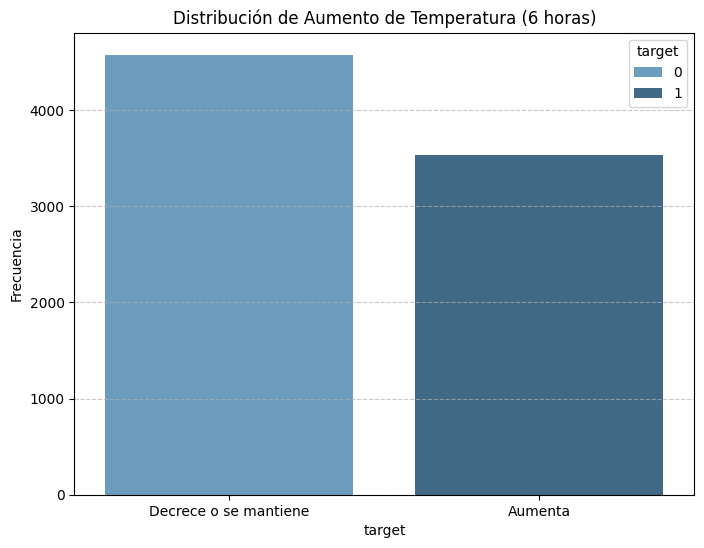

In [338]:
import seaborn as sns

# Class distribution of the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de Aumento de Temperatura (6 horas)")
plt.xticks(ticks=[0, 1], labels=['Decrece o se mantiene', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

**Class distribution by time**

The class distribution remains consistent over time, with similar proportions observed across all months. The "Decrease or maintain" class still has a higher frequency, as previously noted. This suggest that this slight inbalance in the dataset is consistent over time and does not become more pronounced in specific months of the year.

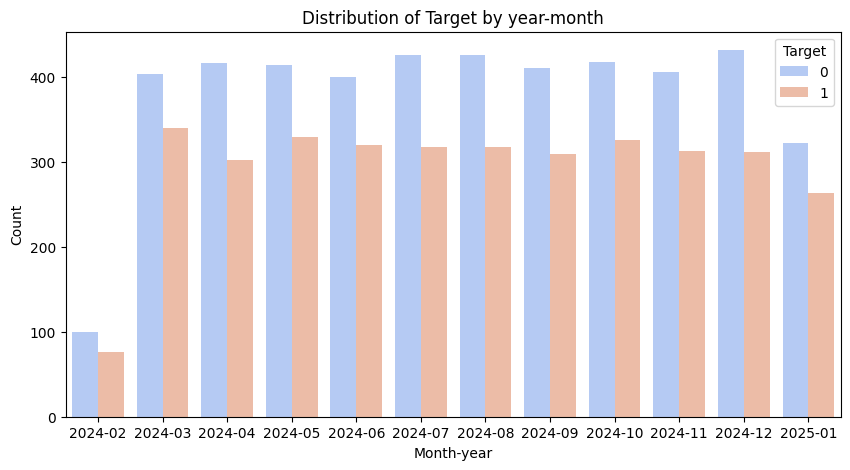

In [339]:
df_plot = copy.deepcopy(df)
df_plot["year_month"] = pd.to_datetime(df_plot["dt"], unit="s").dt.to_period("M")

# Class distribution by month year
plt.figure(figsize=(10, 5))
sns.countplot(data=df_plot, x="year_month", hue="target", palette="coolwarm")
plt.xlabel("Month-year")
plt.ylabel("Count")
plt.title("Distribution of Target by year-month")
plt.legend(title="Target", labels=["0", "1"])
plt.show()

# Train-test partition

In [340]:
# Last 1000 observations are reserved for the test set.
test_df = copy.deepcopy(df.tail(1000))
train_df = copy.deepcopy(df.iloc[:-1000])

X_train = train_df
y_train = X_train.pop('target')
X_test = test_df
y_test = X_test.pop('target')

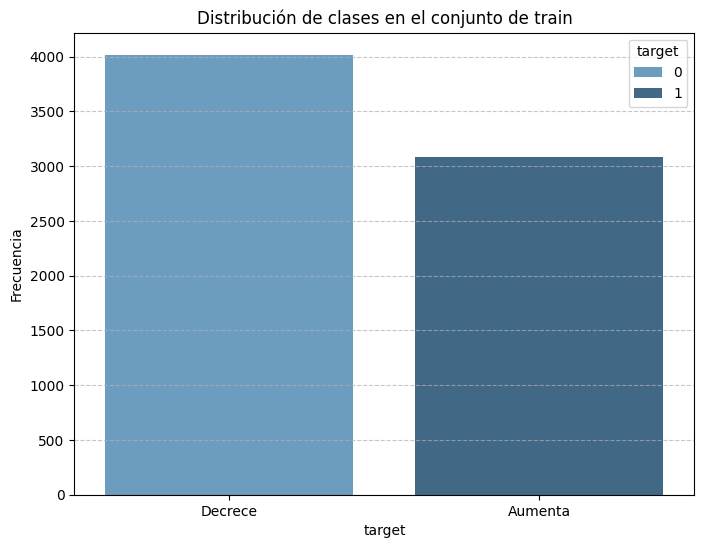

In [341]:
# Class distribution for train set
y_train_df = y_train.to_frame(name="target")
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=y_train_df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el conjunto de train")
plt.xticks(ticks=[0, 1], labels=['Decrece', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

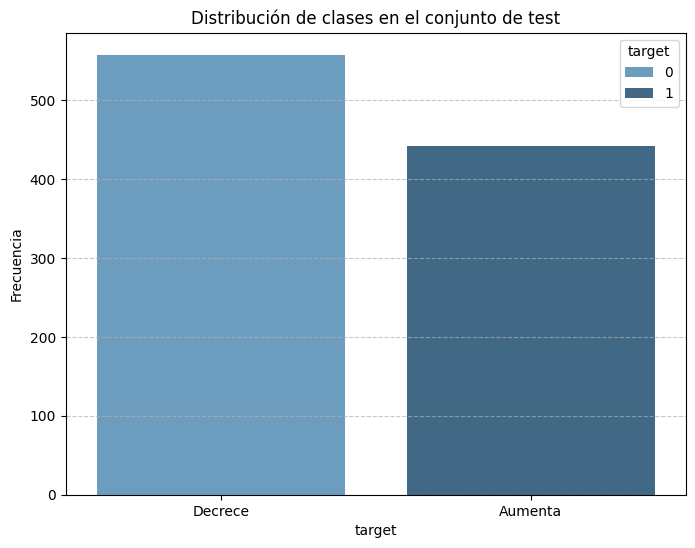

In [342]:
# Class distribution for test set.
y_test_df = y_test.to_frame(name="target")
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=y_test_df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el conjunto de test")
plt.xticks(ticks=[0, 1], labels=['Decrece', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Stream learning results

In [343]:
def create_features(modelo, wrapped=False, colIndex=None):
    """ 
    Creates a river pipeline with a specific preprocessing for given a model.

    Params:
        - modelo: River model to consider.
    """

    cols_rolling = ["main.temp", "main.feels_like", "main.pressure", "main.humidity", "wind.speed", "wind.deg"]
    to_discard = ['Unnamed: 0', 'wind.gust', 'weather.description', 'weather.icon', 'rain.1h', 'temp_diff_6h'
                  "year_month"]
    to_categoric = ["weather.main", "weather.id"]

    # normalize attributes bounded by a fixed range
    to_normalize = ["dt", "wind.deg", "clouds.all", "main.humidity"]
    # for the newly created features that need to be normalized
    to_normalize_new = ["month"]

    # the old attribute will be discarded, the new one hot encoded attribute will remain
    to_discard += to_categoric
    dt = "dt"
    
    # when using the river to sklearn wrapper the names of attributes are lost and replaced by their ordered numerical index
    # by mapping using the column index dict, we solve this problem
    if wrapped:
        to_normalize_new = [] # without this line, batch training fails due to compatibility issues between sklearn and river
        cols_rolling = list(map(colIndex.get, cols_rolling))
        to_discard = list(map(colIndex.get, to_discard))
        to_categoric = list(map(colIndex.get, to_categoric))
        to_normalize = list(map(colIndex.get, to_normalize))
        dt = colIndex[dt]

    def get_date_features(x):
        # likewise we must translate the attribute name "dt" to its ordered index in case of wrapping
        date = x[dt]
            
        date = pd.to_datetime(date, unit = "s")
        # new feature is an integer
        month =  date.month
        
        x['month'] = month
        return x

 
    model = compose.FuncTransformer(get_date_features)

    # pass categorical attribute to an online one hot encoding
    model += (compose.Select(*to_categoric) | preprocessing.OneHotEncoder(drop_zeros=True))
        
    model |= compose.Discard(*to_discard)

    norm_list = to_normalize + to_normalize_new
        
    for col in cols_rolling:
        if col not in norm_list:
            model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 6))

    # create a parallel pipeline to store aggregate the features that will be normalized
    transf_norm = compose.Select(*norm_list)
    for col in cols_rolling:
        if col in norm_list:
            transf_norm += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 6))
            
    model |= compose.TransformerUnion(
        transf_norm | preprocessing.Normalizer(order=2),
        compose.Discard(*norm_list) | preprocessing.StandardScaler()
    )
    model |= modelo

    return model

def stream_learning(X_train, y_train, X_test, y_test, modelo, drift_detect, model_name, is_bin_ddm=False):

    """
    Obtains the results in train and test partition using a specific river pipeline.
    Concept drift is considered using a drift detector, which resets the model when
    a drift is detected.

    Params:
        - X_train: Dataframe with input features in training set.
        - y_train: Dataframe with target in training set.
        - X_test: Dataframe with input features in test set.
        - y_test: Dataframe with target in test set.
        - model: River pipeline to consider.
        - drift_detector: River drift detector to consider.
        - model_name: Name of the model to consider.
    """

    # Lists to store concept drift indexes and accuracy over time
    drifts = []
    ROC_values = []

    # Intialize model, drift detector and metrics
    drift_detector = copy.deepcopy(drift_detect)
    model = copy.deepcopy(modelo)
    ROC = metrics.ROCAUC()
    report2 = metrics.ClassificationReport()

    counter = 0

    # Concatenate X_train and X_test as in stream learning 
    X = pd.concat([X_train, X_test], axis=0)
    y = pd.concat([y_train, y_test], axis=0)

    for xi, yi in stream.iter_pandas(X, y):

        if drift_detector.drift_detected:
            print(f'Change in {model_name} detected at index {counter}')
            # Store position where drift was detected
            drifts.append(counter)
            # Reset model
            model = copy.deepcopy(modelo)
            # Reset drift detector
            drift_detector = copy.deepcopy(drift_detect)

        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)
        
        if is_bin_ddm:
            drift_detector.update(1 if y_pred != yi else 0)
        else:
            drift_detector.update(yi)

        if y_pred != None:
            if counter % 100 == 0 and counter!=0:
                report2.update(yi, y_pred)
                ROC.update(yi, y_pred)
                # Save metric over time
                ROC_values.append(ROC.get())
            counter += 1
            
    return ROC_values, drifts, report2

def get_models_results(X_train, y_train, X_test, y_test, models, drift_detector, is_bin_ddm=False):
    
    """
    Store the results for a model over train and test sets.

    Params:
    - X_train: Dataframe with input features in training set.
    - y_train: Dataframe with target in training set.
    - X_test: Dataframe with input features in test set.
    - y_test: Dataframe with target in test set.
    - model: River model to consider.
    - drift_detector: River drift detector to consider.
    """

    ROCs = []
    drifts = []
    reports = []

    for model in models:
        model_name = model.__class__.__name__
        model_instance = create_features(model)
        accuracies_model, drifts_model, report_model = stream_learning(X_train, y_train, X_test, y_test,
                                                                       modelo=model_instance, drift_detect=drift_detector,
                                                                       model_name=model_name, is_bin_ddm=is_bin_ddm)
        
        ROCs.append(accuracies_model)
        drifts.append(drifts_model)
        reports.append(report_model)

    # Optionally, you can zip the results and print them together
    print("\n")
    for i, model in enumerate(models):
        print(f"Results for {model.__class__.__name__}:")
        print("ROC-AUC:", float(round(ROCs[i][-1],4)))
        print("Drifts:", drifts[i])
        print("Report:", reports[i])
        print("\n")

    return ROCs, drifts, reports

def plot_roc(ROC_list, drifts, colors, labels, title, index_test):
    """
    Plots the results of the model with a detector, visualizing the metrics 
    and concept drift points over time.

    Params:
    - roc_list: List with values of a metric for each model.
    - drifts: List with the detected drifts for each model.
    """

    for i, ROC_values in enumerate(ROC_list):
        color = colors[i]
        label = labels[i]
        indices = np.arange(len(ROC_values))
        indices = indices*100
        plt.plot(indices, ROC_values, label=label, color=color, marker='o')

    for i, drift in enumerate(drifts):
        color = colors[i]
        label = labels[i]
        for value in drift:
            plt.axvline(x=value, color=color, linestyle='--')

    plt.axvline(x=index_test, color="red", linestyle='-', label = "Test set start")

    plt.legend()
    plt.xlabel('Data instances processed')
    plt.ylabel('ROC-AUC')
    plt.title(title)
    plt.show()

# Concept drift detection

Change in LogisticRegression detected at index 408
Change in LogisticRegression detected at index 5283
Change in LogisticRegression detected at index 5785
Change in LogisticRegression detected at index 6283
Change in LogisticRegression detected at index 7238
Change in LogisticRegression detected at index 8080
Change in HoeffdingTreeClassifier detected at index 407
Change in HoeffdingTreeClassifier detected at index 5281
Change in HoeffdingTreeClassifier detected at index 5782
Change in HoeffdingTreeClassifier detected at index 6279
Change in HoeffdingTreeClassifier detected at index 7233
Change in HoeffdingTreeClassifier detected at index 8074
Change in HoeffdingTreeClassifier detected at index 407
Change in HoeffdingTreeClassifier detected at index 5281
Change in HoeffdingTreeClassifier detected at index 5782
Change in HoeffdingTreeClassifier detected at index 6279
Change in HoeffdingTreeClassifier detected at index 7233
Change in HoeffdingTreeClassifier detected at index 8074
Change 

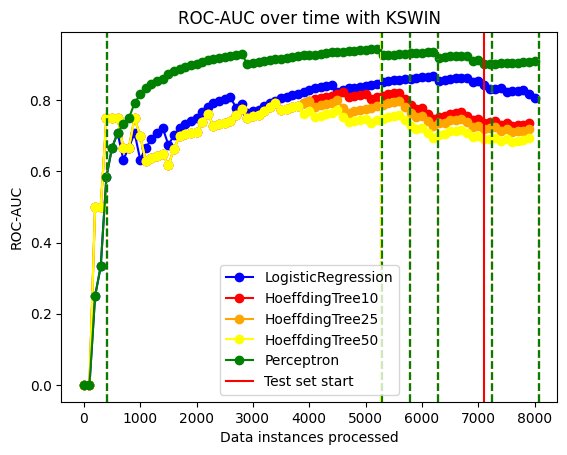

In [344]:
# Define parameters of the experiment.
models = [linear_model.LogisticRegression(),
          tree.HoeffdingTreeClassifier(grace_period=10),
          tree.HoeffdingTreeClassifier(grace_period=25),
          tree.HoeffdingTreeClassifier(grace_period=50),
          linear_model.Perceptron()]
colors = ["blue", "red", "orange", "yellow", "green"]
labels = ["LogisticRegression", "HoeffdingTree10", "HoeffdingTree25", "HoeffdingTree50", "Perceptron"]

# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector=drift.KSWIN(alpha=0.001, seed=42))
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with KSWIN", index_test = len(X_train)+1)



Results for LogisticRegression:
ROC-AUC: 0.8674
Drifts: []
Report:            Precision   Recall   F1       Support  
                                                  
       0      86.00%   93.48%   89.58%        46  
       1      90.32%   80.00%   84.85%        35  
                                                  
   Macro      88.16%   86.74%   87.22%            
   Micro      87.65%   87.65%   87.65%            
Weighted      87.87%   87.65%   87.54%            

                 87.65% accuracy                  


Results for HoeffdingTreeClassifier:
ROC-AUC: 0.8144
Drifts: []
Report:            Precision   Recall   F1       Support  
                                                  
       0      86.96%   81.63%   84.21%        49  
       1      74.29%   81.25%   77.61%        32  
                                                  
   Macro      80.62%   81.44%   80.91%            
   Micro      81.48%   81.48%   81.48%            
Weighted      81.95%   81.48%   81.60%  

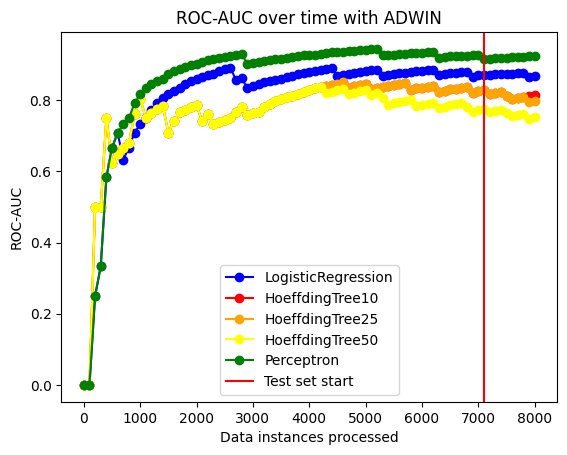

In [243]:
# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector=drift.ADWIN())
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with ADWIN", index_test = len(X_train)+1)

KSWIN (Kolmogorov-Smirnov Windowing) improves the Perceptron as it detects abrupt changes in the data distribution by comparing the current window with a historical window. The Perceptron is significantly affected by changes in data distribution. By detecting these changes and resetting the model, KSWIN allows the Perceptron to adapt more quickly to new conditions, improving its performance.

ADWIN (Adaptive Windowing) fails to detect any drift. This may be because it is designed to detect changes in the mean of the data distribution. If the changes in the data are more gradual or do not significantly affect the mean (but do affect variance or other characteristics), ADWIN does not detect drift. This means that the model continues learning without being reset, which can be beneficial if the data does not change drastically, but detrimental if the model needs to adapt.

### Binary drift detectors

Change in LogisticRegression detected at index 105
Change in LogisticRegression detected at index 204
Change in LogisticRegression detected at index 416
Change in LogisticRegression detected at index 544
Change in LogisticRegression detected at index 660
Change in LogisticRegression detected at index 784
Change in HoeffdingTreeClassifier detected at index 100
Change in HoeffdingTreeClassifier detected at index 203
Change in HoeffdingTreeClassifier detected at index 333
Change in HoeffdingTreeClassifier detected at index 435
Change in HoeffdingTreeClassifier detected at index 552
Change in HoeffdingTreeClassifier detected at index 660
Change in HoeffdingTreeClassifier detected at index 782
Change in HoeffdingTreeClassifier detected at index 991
Change in HoeffdingTreeClassifier detected at index 1119
Change in HoeffdingTreeClassifier detected at index 1233
Change in HoeffdingTreeClassifier detected at index 1649
Change in HoeffdingTreeClassifier detected at index 1841
Change in Hoeffdin

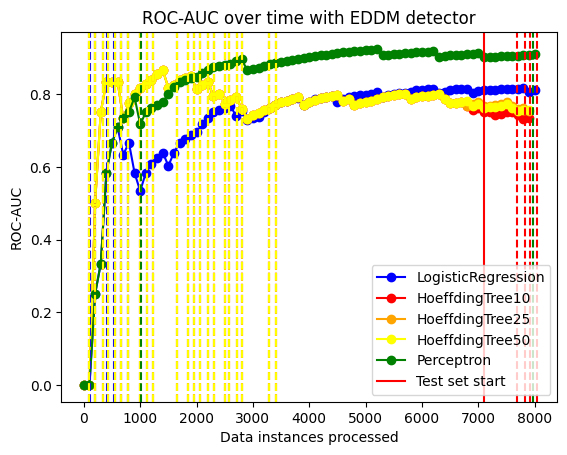

In [249]:
# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector=drift.binary.EDDM(), is_bin_ddm=True)
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with EDDM detector", index_test = len(X_train)+1)

Change in LogisticRegression detected at index 992
Change in LogisticRegression detected at index 1537
Change in LogisticRegression detected at index 1739
Change in LogisticRegression detected at index 3344
Change in HoeffdingTreeClassifier detected at index 322
Change in HoeffdingTreeClassifier detected at index 442
Change in HoeffdingTreeClassifier detected at index 786
Change in HoeffdingTreeClassifier detected at index 991
Change in HoeffdingTreeClassifier detected at index 1532
Change in HoeffdingTreeClassifier detected at index 2747
Change in HoeffdingTreeClassifier detected at index 2907
Change in HoeffdingTreeClassifier detected at index 3336
Change in HoeffdingTreeClassifier detected at index 4550
Change in HoeffdingTreeClassifier detected at index 4970
Change in HoeffdingTreeClassifier detected at index 5330
Change in HoeffdingTreeClassifier detected at index 5785
Change in HoeffdingTreeClassifier detected at index 5924
Change in HoeffdingTreeClassifier detected at index 6502

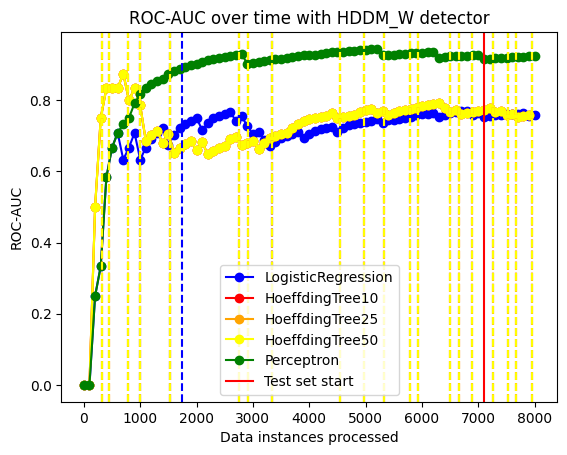

In [250]:
# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector=drift.binary.HDDM_W(), is_bin_ddm=True)
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with HDDM_W detector", index_test = len(X_train)+1)

EDDM (Early Drift Detection Method) slightly improves the Hoeffding Trees since it is more sensitive to gradual changes in the error rate. Therefore, when a significant drift occurs, EDDM enables the model to detect the change and adjust more quickly.

HDDM_W (Hoeffding Drift Detection Method – Weighted) considerably improves the Hoeffding Trees as it detects changes based on the distribution of recent errors, giving more weight to recent observations. Since this detector is more reactive to changes in the data, when it detects a drift, it forces the Hoeffding Trees to reset or adjust specific parts of the tree. This significantly enhances their adaptability compared to not using a detector or using a less reactive one like EDDM.

The graphs for KSWIN and HDDM_W show that they detect more drifts in the same regions, while they detect fewer drifts in the middle of the graph. This is likely because the middle months have more stable and predictable weather conditions, making sudden distribution shifts less frequent.

# Batch learning results

The batch learning struggles with concept drift because it relies on training the model on a fixed dataset without continuous updates. This makes this approach not ideal for environments like this one that need continuous adaptation. Performing some re-training to the model could be a way to handle a concept dift with batch learning, however, this can be inefficient and expensive, especially when frequent updates are needed.

In [345]:
def get_sklearn_results(X_train, y_train, X_test, y_test, models, labels, colIndex):
    
    # Cross-validation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(roc_auc_score)

    for i, model in enumerate(models):

        # Create river pipeline and convert to sklearn
        river_pipeline = create_features(model, wrapped=True, colIndex=colIndex)
        sk_pipeline = compat.convert_river_to_sklearn(river_pipeline)

        # Print cross-validation and test results for each model
        print(f"Results for {labels[i]}:")
        scores = cross_val_score(sk_pipeline, X_train, y_train, scoring=scorer, cv=cv)
        print(f'Cross-validation train ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')
        sk_pipeline.fit(X_train, y_train)
        y_pred = sk_pipeline.predict_proba(X_test)[:, 1]
        test_score = roc_auc_score(y_test, y_pred)
        print(f'Test partition ROC AUC: {test_score:.4f} \n')

In [349]:

colIndex = {v: k for k, v in enumerate(X_train.columns)}

labels = ["LogisticRegression Default", "LogisticRegression l2=0.01", "LogisticRegression l2=0.5", "HoeffdingTree10", "HoeffdingTree25", 
          "HoeffdingTree50", "Perceptron Default", "Perceptron l2=0.01", "Perceptron clip_gradient=1.0", "Perceptron l2=0.5"]

models = [
    linear_model.LogisticRegression(),
    linear_model.LogisticRegression(l2=0.01),
    linear_model.LogisticRegression(l2=0.5),
    tree.HoeffdingTreeClassifier(grace_period=10),
    tree.HoeffdingTreeClassifier(grace_period=25),
    tree.HoeffdingTreeClassifier(grace_period=50),
    linear_model.Perceptron(),
    linear_model.Perceptron(l2=0.01),  # Perceptron with low L2 regularization
    linear_model.Perceptron(clip_gradient=1.0),  # Perceptron con gradiente limitado
    linear_model.Perceptron(l2=0.5)  # Perceptron with higher L2 regularization
]

get_sklearn_results(X_train, y_train, X_test, y_test, models, labels, colIndex)


Results for LogisticRegression Default:
Cross-validation train ROC AUC: 0.6543 (± 0.0130)
Test partition ROC AUC: 0.6830 

Results for LogisticRegression l2=0.01:
Cross-validation train ROC AUC: 0.6544 (± 0.0107)
Test partition ROC AUC: 0.6906 

Results for LogisticRegression l2=0.5:
Cross-validation train ROC AUC: 0.6589 (± 0.0063)
Test partition ROC AUC: 0.7596 

Results for HoeffdingTree10:
Cross-validation train ROC AUC: 0.6923 (± 0.0234)
Test partition ROC AUC: 0.4901 

Results for HoeffdingTree25:
Cross-validation train ROC AUC: 0.6739 (± 0.0256)
Test partition ROC AUC: 0.5851 

Results for HoeffdingTree50:
Cross-validation train ROC AUC: 0.6765 (± 0.0212)
Test partition ROC AUC: 0.5851 

Results for Perceptron Default:
Cross-validation train ROC AUC: 0.4743 (± 0.0451)
Test partition ROC AUC: 0.3547 

Results for Perceptron l2=0.01:
Cross-validation train ROC AUC: 0.3778 (± 0.0111)
Test partition ROC AUC: 0.2778 

Results for Perceptron clip_gradient=1.0:
Cross-validation train R

Logistic Regression with an L2=0.5 had the best test performance (0.7596) of every model, while having a reasonable cross-validation score. This indicates that stronger regularization improved generalization substantially.

Hoeffding Tree models performed better than the other models in cross-validation, but their test performance varied significantly. As HoeffdingTree10 had the lowest grace period it was also the most liable to overfitting due to more decision splitting, which is reflected in its lower test score. HoeffdingTree25 and HoeffdingTree50 had the best balance and perform equally well.

Perceptron models performed poorly across the board, with ROC AUC scores below random chance (0.5) in cross-validation and even worse on the test partitions, indicating they are not suitable for this problem from a classical ML approach. 
